### TRAIN MODEL

In [2]:
import pandas as pd
import numpy as np

In [ ]:
train_data = pd.read_csv('train_data', sep=";")

In [177]:
train_data.select_dtypes(exclude=[object, bool]).columns

Index(['user_id', 'post_id', 'target', 'text_length', 'likes', 'posts_views',
       'likes_share', 'gender', 'age', 'business', 'covid', 'entertainment',
       'movie', 'politics', 'sport', 'tech', 'views', 'ratio of likes posts'],
      dtype='object')

In [178]:
numeric_columns = train_data.select_dtypes(exclude=[object, bool]).columns
numeric_columns = numeric_columns.drop(['target', 'gender', 'age'])
numeric_columns

Index(['user_id', 'post_id', 'text_length', 'likes', 'posts_views',
       'likes_share', 'business', 'covid', 'entertainment', 'movie',
       'politics', 'sport', 'tech', 'views', 'ratio of likes posts'],
      dtype='object')

In [179]:
categorical_columns

['topic', 'age', 'city']

In [180]:
categorical_columns = []

for col in train_data.columns:
    if col not in numeric_columns.tolist() and col not in ['target', 'gender', 'country', 'os', 'source', 'timestamp']:
        categorical_columns.append(col)

In [181]:
train_data = train_data.sort_values('timestamp')

In [182]:
train_data_update = train_data.drop(columns=['gender', 'country', 'os', 'source'])

In [194]:
for col in ['topic','city']:
        mean_target = train_data_update.groupby(col)['target'].mean()
        train_data_update[col] = train_data_update[col].map(mean_target)

In [197]:
train_data_update[train_data_update['target']==0].shape[0], train_data_update[train_data_update['target']==1].shape[0]

MemoryError: Unable to allocate 32.8 MiB for an array with shape (4295656, 1) and data type int64

In [1]:
train_data_update.topic.value_counts()

NameError: name 'train_data_update' is not defined

In [164]:
from sklearn.model_selection import train_test_split

X = train_data_update.drop(columns=['target','timestamp'])
y = train_data_update['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=False, #предварительно посортировали по дате
                                                    test_size=0.2)

X_train_clear = X_train.drop(columns=['user_id', 'post_id'])
X_test_clear = X_test.drop(columns=['user_id', 'post_id'])

In [166]:
X_train_clear

,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts
1364185,0.139795,432,702.0,6759.0,10.0,17,0.175934,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.2,15,0.133333
4950977,0.139795,2872,684.0,6633.0,10.0,15,0.077175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,15,0.000000
4580075,0.139795,705,713.0,6834.0,10.0,15,0.172582,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.0,15,0.133333
4642628,0.138342,140,2591.0,16898.0,15.0,52,0.088398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,15,0.000000
4904478,0.138342,126,732.0,6832.0,10.0,20,0.158872,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,15,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439689,0.139795,635,2713.0,16821.0,16.0,37,0.174588,0.272727,0.166667,0.000000,0.113636,0.125000,0.117647,0.0,113,0.132743
2431699,0.138342,138,2690.0,16865.0,15.0,39,0.116767,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,113,0.061947
3920275,0.132480,3220,838.0,12074.0,6.0,18,0.173719,0.000000,0.281250,0.400000,0.166667,0.333333,0.133333,0.0,113,0.203540
1902600,0.139795,2876,636.0,6651.0,9.0,24,0.134316,0.333333,0.068966,0.333333,0.065217,0.000000,0.416667,0.0,113,0.132743


In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
model_LR = LogisticRegression(random_state=42, verbose=0,class_weight={0:1.0,1:1.6})
pipe_LR = Pipeline([('scaler', StandardScaler()), ('LR', model_LR)])

In [168]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
splitter = TimeSeriesSplit(n_splits=5)
pipe_LR.fit(X_train_clear, y_train)
cv_model_LR = cross_validate(pipe_LR, X_train_clear, y_train,
                              scoring='roc_auc',cv=splitter,return_train_score=True)

In [188]:
import joblib, pickle
joblib.dump(pipe_LR, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [190]:
pipe_LR = joblib.load('logistic_regression_model.pkl')

In [191]:
train_LR = round(np.mean(cv_model_LR['train_score']),3)
Test_LR = round(np.mean(cv_model_LR['test_score']),3)
Finaly_test_LR = round(pipe_LR.score(X_test_clear, y_test),3)

print(f"train LR: {train_LR}")
print(f"Test LR: {Test_LR}")
print(f"Finaly test LR: {Finaly_test_LR}")

train LR: 0.685
Test LR: 0.687
Finaly test LR: 0.853


In [12]:
from catboost import CatBoostClassifier
cat_boost = CatBoostClassifier(iterations=300, verbose=50)

cat_boost.fit(X_train_clear, y_train, cat_features=categorical_columns)

Learning rate set to 0.5
0:	learn: 0.4247254	total: 2.98s	remaining: 14m 50s
50:	learn: 0.2981032	total: 2m 2s	remaining: 9m 59s
100:	learn: 0.2925693	total: 4m 5s	remaining: 8m 3s
150:	learn: 0.2897816	total: 6m 3s	remaining: 5m 59s
200:	learn: 0.2875483	total: 7m 52s	remaining: 3m 52s
250:	learn: 0.2862266	total: 9m 13s	remaining: 1m 47s
299:	learn: 0.2853085	total: 10m 37s	remaining: 0us


In [25]:
cat_boost.save_model('catboost_model_1', format="cbm")

In [170]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

predict_train = pipe_LR.predict(X_train_clear)
predict_test = pipe_LR.predict(X_test_clear)
f1_train = f1_score(y_train, predict_train)
f1_test = f1_score(y_test, predict_test)

print(f'F1 score на трейне {f1_train}, на тесте {f1_test}')

F1 score на трейне 0.07874156572636372, на тесте 0.07337621965919329


In [171]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

predict_train = cat_boost.predict(X_train_clear)
predict_test = cat_boost.predict(X_test_clear)
f1_train = f1_score(y_train, predict_train)
f1_test = f1_score(y_test, predict_test)

print(f'F1 score на трейне {f1_train}, на тесте {f1_test}')

NameError: name 'cat_boost' is not defined

In [172]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

predict_test = pipe_LR.predict(X_test_clear)

recall = recall_score(y_test, predict_test)
precision = precision_score(y_test, predict_test)
roc_auc = roc_auc_score(y_test, predict_test)

print(f'recall = {recall}, precision = {precision}, roc_auc = {roc_auc}')

recall = 0.040933768412409664, precision = 0.3537219401798275, roc_auc = 0.5142929193357494


In [14]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

predict_test = cat_boost.predict(X_test_clear)

recall = recall_score(y_test, predict_test)
precision = precision_score(y_test, predict_test)
roc_auc = roc_auc_score(y_test, predict_test)

print(f'recall = {recall}, precision = {precision}, roc_auc = {roc_auc}')

recall = 0.16979409245666316, precision = 0.6165946946329426, roc_auc = 0.5761812729926972


In [135]:
prob = pipe_LR.predict_proba(X_test_clear)

In [136]:
first_class_prob = []
for row in range(X_test.shape[0]):
    first_class_prob.append(prob[row][1])

In [137]:
X_test['prob'] = first_class_prob
X_test['target'] = y_test

In [138]:
X_test.head()

,user_id,post_id,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts,prob,target
2037726,88017,986,0.132480,2930,2781.0,22171.0,12.0,0.137591,0.109195,0.333333,0.090909,0.166667,0.052632,0.000000,0.000000,0.000000,113,0.061947,0.115900,0
200957,137037,1148,0.132480,1784,881.0,12083.0,7.0,0.142331,0.064808,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,113,0.035398,0.062781,0
283555,123437,3002,0.138342,138,2636.0,16858.0,15.0,0.135602,0.127764,0.333333,0.043478,0.200000,0.160000,0.000000,0.200000,0.000000,113,0.132743,0.233777,0
3725476,94927,2933,0.138342,138,2608.0,17034.0,15.0,0.135602,0.158600,0.500000,0.156250,0.333333,0.130435,0.000000,0.000000,0.333333,113,0.132743,0.240286,0
698568,81148,3648,0.138342,131,1601.0,17396.0,9.0,0.137481,0.222402,0.166667,0.172414,0.500000,0.216216,0.307692,0.333333,0.000000,113,0.238938,0.295677,0


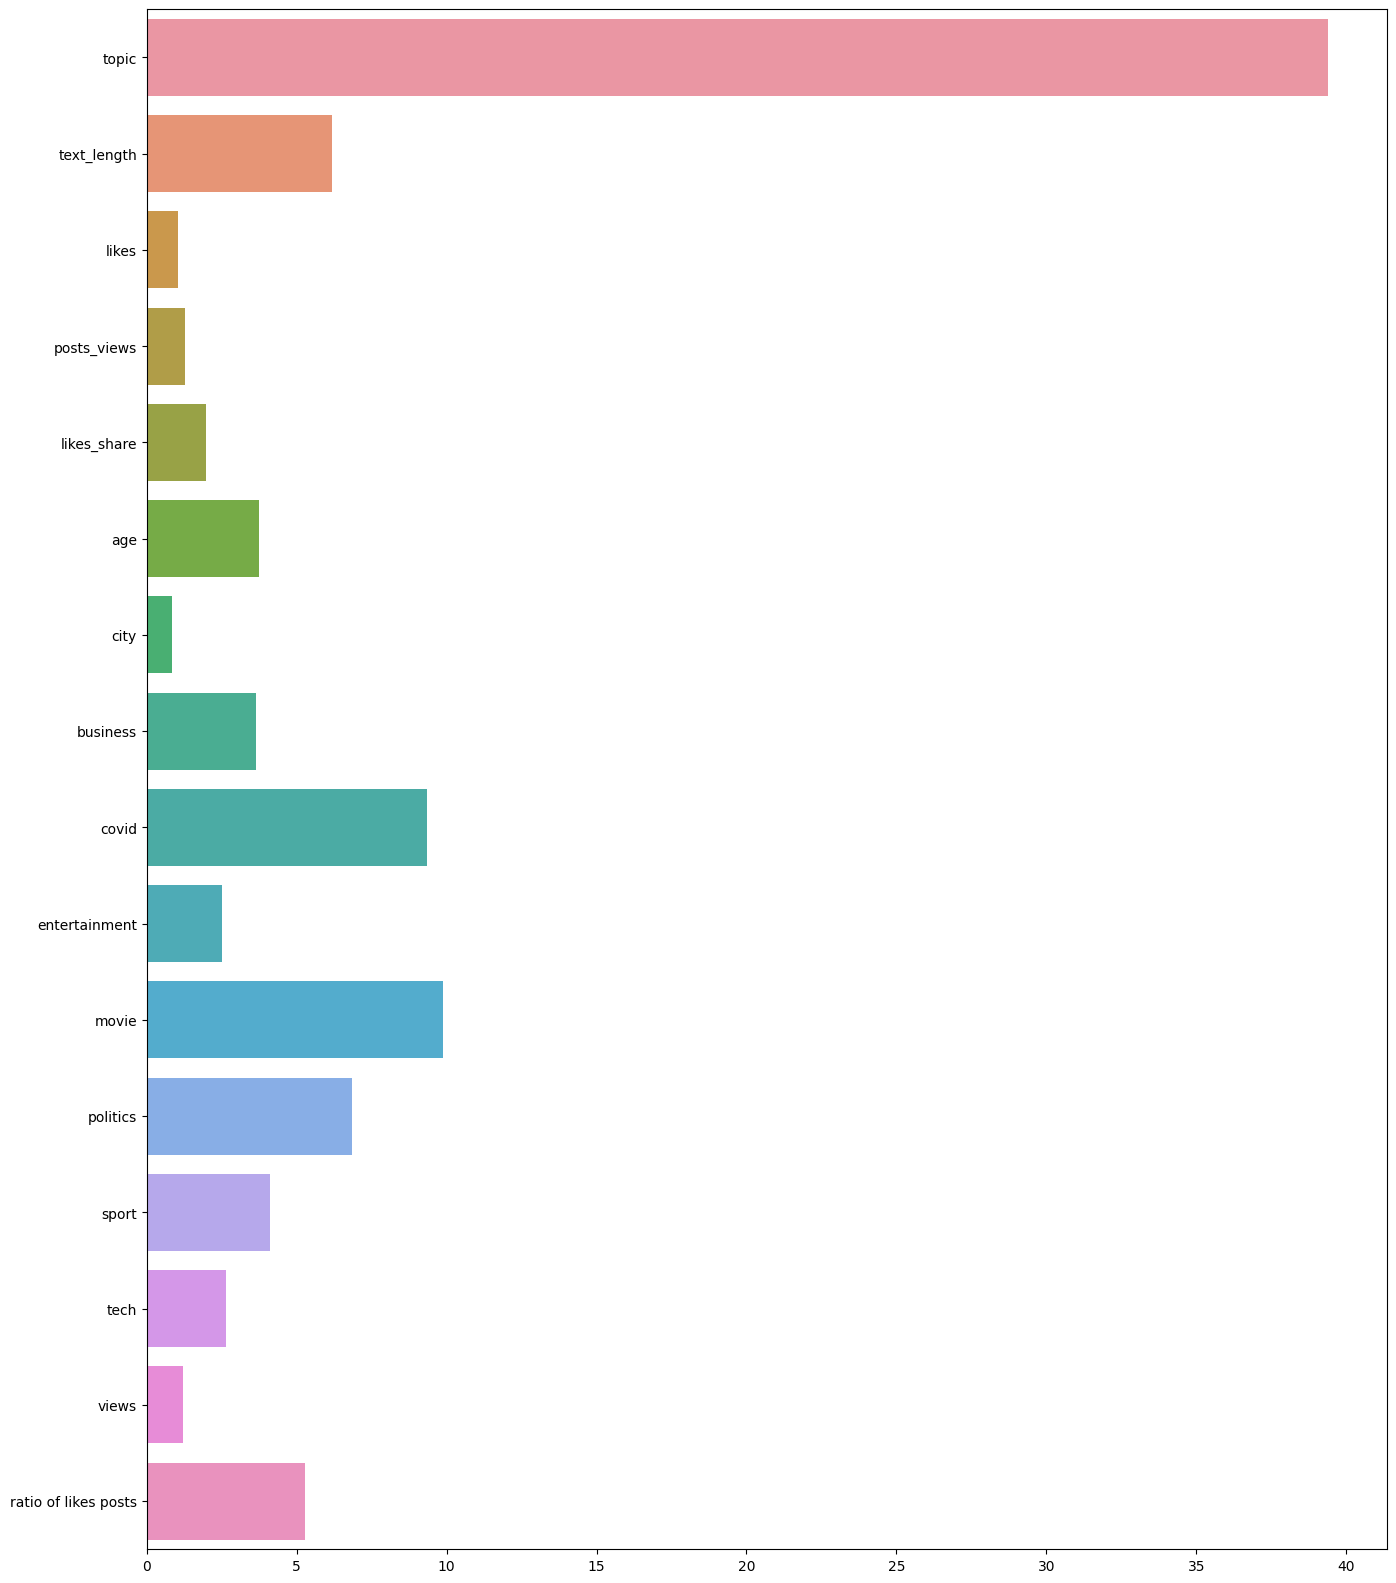

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(16, 20)

sns.barplot(x=cat_boost.feature_importances_,
            y=X_test_clear.columns)


plt.show()

In [22]:
X_test.head()

,user_id,post_id,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts,prob,target
2037726,88017,986,politics,2930,2781.0,22171.0,12.0,40,Beya,0.333333,0.090909,0.166667,0.052632,0.000000,0.000000,0.000000,113,0.061947,0.000414,0
200957,137037,1148,politics,1784,881.0,12083.0,7.0,34,Kirov,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,113,0.035398,0.000191,0
283555,123437,3002,covid,138,2636.0,16858.0,15.0,39,Zavitinsk,0.333333,0.043478,0.200000,0.160000,0.000000,0.200000,0.000000,113,0.132743,0.019996,0
3725476,94927,2933,covid,138,2608.0,17034.0,15.0,39,Tomsk,0.500000,0.156250,0.333333,0.130435,0.000000,0.000000,0.333333,113,0.132743,0.052724,0
698568,81148,3648,covid,131,1601.0,17396.0,9.0,36,Shymkent,0.166667,0.172414,0.500000,0.216216,0.307692,0.333333,0.000000,113,0.238938,0.104373,0


In [139]:
users_hitrate = []

for user in X_test['user_id'].unique():
    part = X_test[X_test['user_id']==user]
    part = part.sort_values('prob', ascending=False).head(5).reset_index()
    
    users_hitrate_ = []
    
    for i in part.target:
        if i == 1:
            users_hitrate_.append(1)
        else:
            users_hitrate_.append(0)
    
    users_hitrate_metric =  max(users_hitrate_)
    
    users_hitrate.append(users_hitrate_metric)
    
print(f"Среднее Hitrate@5 по пользователям из теста: {np.mean(users_hitrate)}")

Среднее Hitrate@5 по пользователям из теста: 0.5775996637848223


In [140]:
X_train

,user_id,post_id,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts
1364185,91677,5385,0.139795,432,702.0,6759.0,10.0,0.137722,0.175934,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.2,15,0.133333
4950977,161005,6782,0.139795,2872,684.0,6633.0,10.0,0.134386,0.077175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,15,0.000000
4580075,40293,6437,0.139795,705,713.0,6834.0,10.0,0.134386,0.172582,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.0,15,0.133333
4642628,133794,3545,0.138342,140,2591.0,16898.0,15.0,0.141022,0.088398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,15,0.000000
4904478,26676,3330,0.138342,126,732.0,6832.0,10.0,0.138046,0.158872,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,15,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439689,29927,6988,0.139795,635,2713.0,16821.0,16.0,0.134528,0.174588,0.272727,0.166667,0.000000,0.113636,0.125000,0.117647,0.0,113,0.132743
2431699,45513,3358,0.138342,138,2690.0,16865.0,15.0,0.135602,0.116767,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,113,0.061947
3920275,143840,1018,0.132480,3220,838.0,12074.0,6.0,0.137197,0.173719,0.000000,0.281250,0.400000,0.166667,0.333333,0.133333,0.0,113,0.203540
1902600,23119,7094,0.139795,2876,636.0,6651.0,9.0,0.137404,0.134316,0.333333,0.068966,0.333333,0.065217,0.000000,0.416667,0.0,113,0.132743
